In [129]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor, HuberRegressor, PassiveAggressiveRegressor, BayesianRidge, LinearRegression
from sklearn.neural_network import MLPRegressor
from joblib import dump, load


pd.set_option('display.max_columns', None)

In [114]:
def find_non_numeric(dataframe):
    # List to store locations of non-numeric values
    non_numeric_locations = []
    
    # Loop over each column
    for col in df.columns:
        # Check if the column's dtype is not numeric
        if not pd.api.types.is_numeric_dtype(df[col]):
            # Iterate over the rows to find non-numeric values
            for idx, val in df[col].iteritems():
                try:
                    # Try to convert to float to identify if it's numeric
                    float(val)
                except (ValueError, TypeError):
                    # If conversion fails, store the location
                    non_numeric_locations.append((idx, col, val))
    
    return non_numeric_locations

In [115]:

DATABASE = '../data/processed/base_ml.pkl'
MODELS =  '../models/'

# Charger le dataframe nettoyé et complété
df = pd.read_pickle(DATABASE)


In [116]:
# Aperçu du fichier
df.head()

,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
0,000412-01012018,F261,2018-01-01,74,191,265,F26,Bethnal Green,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Park,Open land/water - nearest gazetteer location,Bethnal Green,1,1,1,Domestic Incidents,Effecting entry/exit,0,0.629,2,1,F26,F26,0,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
1,000413-01012018,G272,2018-01-01,85,109,194,G27,North Kensington,Home Station,1,No delay,Pump Ladder,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,North Kensington,1,1,1,Domestic Incidents,Effecting entry/exit,0,0.849,3,2,G27,G27,0,2,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
2,000415-01012018,G301,2018-01-01,72,167,239,G30,Wembley,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Tree scrub,On land associated with building,Wembley,1,1,1,Fire,Secondary Fire,0,1.319,4,2,G30,G30,0,2,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
3,000417-01012018,G291,2018-01-01,123,364,487,G29,Park Royal,Home Station,1,Address incomplete/wrong,Pump Dual Ladder,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Wembley,2,2,1,Fire,False alarm - Good intent,1,1.296,3,2,G29,G30,1,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
4,000417-01012018,G281,2018-01-01,40,453,493,G28,Willesden,Home Station,2,Address incomplete/wrong,Pump Dual Ladder,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Wembley,2,2,1,Fire,False alarm - Good intent,1,2.728,4,2,G28,G30,1,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547865 entries, 0 to 547864
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   IncidentNumber                 547865 non-null  object        
 1   Resource_Code                  547865 non-null  object        
 2   DateAndTimeMobilised           547865 non-null  datetime64[ns]
 3   TurnoutTimeSeconds             547865 non-null  int64         
 4   TravelTimeSeconds              547865 non-null  int64         
 5   AttendanceTimeSeconds          547865 non-null  int64         
 6   DeployedFromStation_Code       547865 non-null  object        
 7   DeployedFromStation_Name       547865 non-null  object        
 8   DeployedFromLocation           547865 non-null  object        
 9   PumpOrder                      547865 non-null  int64         
 10  DelayCode_Description          547865 non-null  object        
 11  Appli

In [118]:
# Jeux de données entrainement et test : travaux préliminaire pour choix des numéros d'incidents

# paramètres généraux
tts_test_size = 0.2    # définir la proportion du nombre d'incidents à affecter au jeu de test
np.random.seed(42)     # fixer le caractère aléatoire (même base + même seed => donnera même liste dans les 3 modèles)

# Faire la liste des incidents et la trier
tts_inc_list = df['IncidentNumber'].unique().tolist()
tts_inc_list.sort()

# Total des véhicules et incidents pour juger de la répartition train / test
tts_nb_pump = df.shape[0]
tts_nb_inc = len(tts_inc_list)

# Taille de la liste des incidents à mettre en jeu de test
tts_test_size_nb = np.int64(tts_nb_inc * tts_test_size)

# liste des n° d'incidents à garder dans le jeu de test = sélectionner 'test_size_nb' éléments de la liste, par un tirage sans remise
tts_inc_test_list = list(np.random.choice(tts_inc_list, tts_test_size_nb, replace= False))

# sauvegarder les index des lignes des incidents que l'on affectera en test et train
# car nous allons ensuite supprimer la variable 'IncidentNumber'
tts_index_test = df[df['IncidentNumber'].isin(tts_inc_test_list)].index
tts_index_train = df[~df['IncidentNumber'].isin(tts_inc_test_list)].index

In [119]:
# suppression toutes les variables datetime
df = df.drop(df.select_dtypes("datetime").columns, axis = 1)
df = df[[
    # 'IncidentNumber',                  # REMOVE # not useful
    # 'Resource_Code',                   # REMOVE # corresponds to Station_Code_of_ressource + Appliance
    # 'DateAndTimeMobilised',            # REMOVE # already removed above
    # 'TurnoutTimeSeconds',              # REMOVE # not useful
    # 'TravelTimeSeconds',               # REMOVE # not useful
    'AttendanceTimeSeconds',             # Target variable
    # 'DeployedFromStation_Code',        # REMOVE # corresponds to Station_Code_of_ressource
    # 'DeployedFromStation_Name',        # REMOVE # corresponds to Station_Code_of_ressource
    'DeployedFromLocation',              # Home station or Other station
    # 'PumpOrder',                       # REMOVE # information determined post-incident
    # 'DelayCode_Description',           # REMOVE
    'Appliance',                         # Type of vehicle
    'PropertyCategory',                  # Retained for now, will review its impact versus 9 other columns
    # 'PropertyType',                    # REMOVE # covered by the 9 property columns
    'AddressQualifier',                  # To be kept
    # 'IncidentStationGround',           # REMOVE # replaced by IncidentStationGround_Code below
    # 'NumStationsWithPumpsAttending',   # REMOVE # post-incident information
    # 'NumPumpsAttending',               # REMOVE # post-incident information / subject of Christophe's predictions
    # 'TimeOnIncidentSeconds',           # REMOVE # post-incident information
    # 'TimeTotalSeconds',                # REMOVE # post-incident information
    # 'Mobilised_Rank',                  # REMOVE # dataset already filtered on value = 1
    # 'Outdoor Structure',               # REMOVE # 9-column group related to property
    # 'Road Vehicle',                    # REMOVE # 9-column group related to property
    # 'Outdoor',                         # REMOVE # 9-column group related to property
    # 'Dwelling',                        # REMOVE # 9-column group related to property
    # 'Other Residential',               # REMOVE # 9-column group related to property
    # 'Aircraft',                        # REMOVE # 9-column group related to property
    # 'Boat',                            # REMOVE # 9-column group related to property
    # 'Rail Vehicle',                    # REMOVE # 9-column group related to property
    # 'Non Residential',                 # REMOVE # 9-column group related to property
    'IncidentType',                      # 6 categories to be one-hot encoded
    # 'IncidentCategory',                # REMOVE # too many categories, detail level of IncidentType + post-incident info
    # 'FalseAlarm',                      # REMOVE # post-incident information
    'Distance',                          # Important distance parameter
    'TotalOfPumpInLondon_Out',           # Parameter for station congestion at the time of the call
    # 'PumpByStation',                   # REMOVE # number of pumps at the station, already covered by the number available
    'Station_Code_of_ressource',         # Station code of the vehicle sent to this call
    'IncidentStationGround_Code',        # Station code responsible for the location of the incident (station responsible for the area)
    # 'PumpOfIncidentStation_Out',       # REMOVE # already have the number of available pumps
    'PumpAvailable',                     # Number of pumps available (not on call) at the StationGround
    # 'year',                            # REMOVE # not needed
    'month',                             # To be kept
    # 'day',                             # REMOVE # day of the month, kept after review on 24/02/22, removed after discussion on 14/03/22
    # 'weekday',                         # REMOVE # now integrated into congestion rate
    # 'hour',                            # REMOVE # now integrated into congestion rate
    'temp',                              # To be kept
    'precip',                            # To be kept
    'cloudcover',                        # To be kept
    'visibility',                        # To be kept
    'conditions',                        # To be kept
    # 'icon',                            # REMOVE # duplicate of conditions
    # 'blank',                           # REMOVE # removed on 14/03/22, replaced by 2 other columns
    'workingday',                        # To be kept
    'school_holidays',                   # To be kept
    'congestion_rate',                   # Traffic congestion rate
]]

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547865 entries, 0 to 547864
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AttendanceTimeSeconds       547865 non-null  int64  
 1   DeployedFromLocation        547865 non-null  object 
 2   Appliance                   547865 non-null  object 
 3   PropertyCategory            547865 non-null  object 
 4   AddressQualifier            547865 non-null  object 
 5   IncidentType                547865 non-null  object 
 6   Distance                    547865 non-null  float64
 7   TotalOfPumpInLondon_Out     547865 non-null  int64  
 8   Station_Code_of_ressource   547865 non-null  object 
 9   IncidentStationGround_Code  547865 non-null  object 
 10  PumpAvailable               547865 non-null  int64  
 11  month                       547865 non-null  int64  
 12  temp                        547865 non-null  float64
 13  precip             

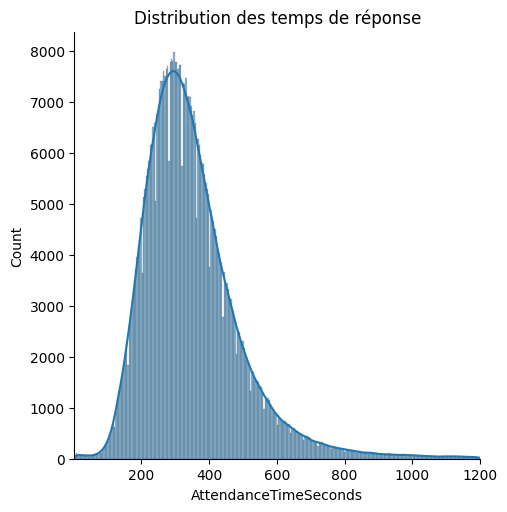

In [121]:
# Distribution des temps de réponse
sns.displot(df['AttendanceTimeSeconds'], kde=True)
plt.title('Distribution des temps de réponse')
plt.xlim([df['AttendanceTimeSeconds'].min(), df['AttendanceTimeSeconds'].max()]);


In [122]:
# First, ensure all object columns are converted to numeric codes using .assign
df_corr = df.assign(
    location_home_other = df.DeployedFromLocation.astype('category').cat.codes,
    appliance = df.Appliance.astype('category').cat.codes,
    prop_cat = df.PropertyCategory.astype('category').cat.codes,
    addr_qualifier = df.AddressQualifier.astype('category').cat.codes,
    inc_type = df.IncidentType.astype('category').cat.codes,
    station_ressource = df.Station_Code_of_ressource.astype('category').cat.codes,
    conditions = df.conditions.astype('category').cat.codes,
    workingday = df.workingday.astype('category').cat.codes,
    school_holidays = df.school_holidays.astype('category').cat.codes,
    station_ground = df.IncidentStationGround_Code.astype('category').cat.codes
)

In [123]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 547865 entries, 0 to 547864
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AttendanceTimeSeconds       547865 non-null  int64  
 1   DeployedFromLocation        547865 non-null  object 
 2   Appliance                   547865 non-null  object 
 3   PropertyCategory            547865 non-null  object 
 4   AddressQualifier            547865 non-null  object 
 5   IncidentType                547865 non-null  object 
 6   Distance                    547865 non-null  float64
 7   TotalOfPumpInLondon_Out     547865 non-null  int64  
 8   Station_Code_of_ressource   547865 non-null  object 
 9   IncidentStationGround_Code  547865 non-null  object 
 10  PumpAvailable               547865 non-null  int64  
 11  month                       547865 non-null  int64  
 12  temp                        547865 non-null  float64
 13  precip             

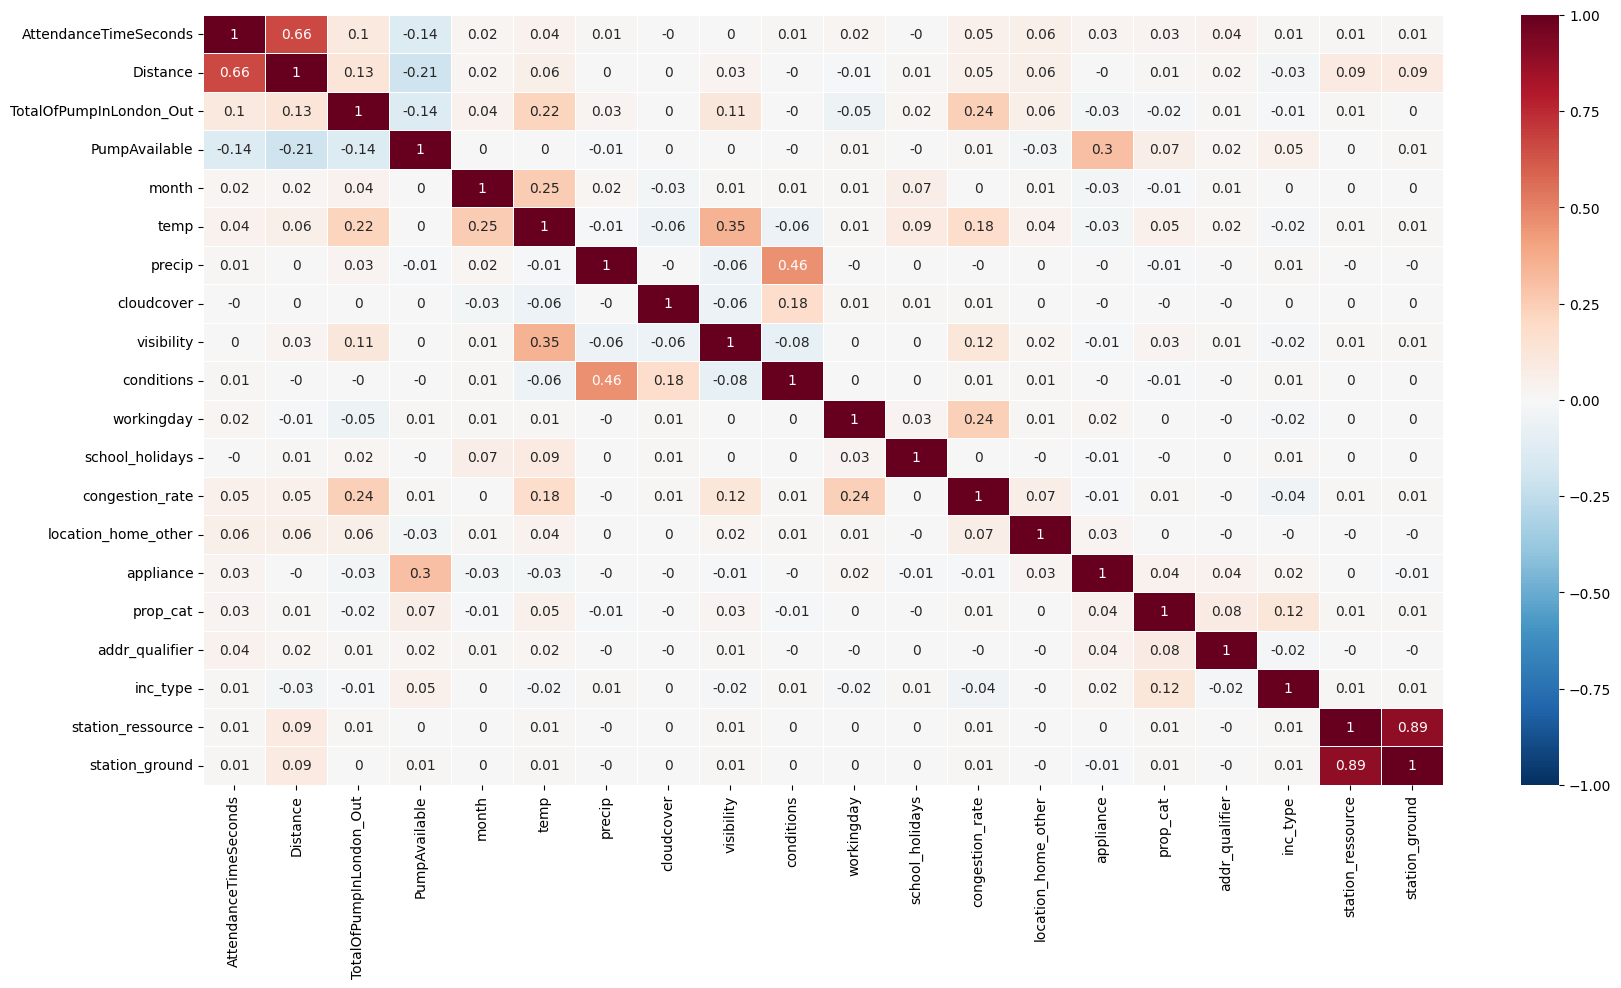

In [124]:

# Now, drop the original object columns (if necessary) before calling .corr()
df_corr = df_corr.drop(columns=[
    'DeployedFromLocation', 'Appliance', 'PropertyCategory', 'AddressQualifier', 
    'IncidentType', 'Station_Code_of_ressource', 'IncidentStationGround_Code'
])

# Calculate the correlation matrix
corr_matrix = np.round(df_corr.corr(), 2)
plt.figure(figsize=(20, 10))
# Visualize the correlation matrix with seaborn's heatmap
sns.heatmap(corr_matrix, center=0, cmap='RdBu_r', annot=True, vmin=-1, vmax=1, linewidths=0.5)
plt.show()

In [125]:
def reg_var_type(df):
    """
    Corriger les types pour 4 variables d'un df,
    et les rendre exploitable comme souhaité pour le ML.
    Variables concernées :
        PumpAvailable, month, workingday, school_holidays
    """
    # convertir 'PumpAvailable' (considérée catégorielle / paliers / peu de modalités) au format string (en vue de dichotomisation)
    df['PumpAvailable'] = df['PumpAvailable'].astype(str)
    print("'PumpAvailable' a été converti en 'object'")

    # convertir 'month' au format integer
    df['month'] = df['month'].astype('uint8')
    print("'month' a été converti en 'uint8'")

    # convertir 'workingday' et 'school_holidays' au format integer (variables binaires 0/1, pour ne pas dichotomiser)
    df['workingday'] = df['workingday'].astype('uint8')
    print("'workingday' a été converti en 'uint8'")
    df['school_holidays'] = df['school_holidays'].astype('uint8')
    print("'school_holidays' a été converti en 'uint8'\n")

    return df.info()

reg_var_type(df)

'PumpAvailable' a été converti en 'object'
'month' a été converti en 'uint8'
'workingday' a été converti en 'uint8'
'school_holidays' a été converti en 'uint8'

<class 'pandas.core.frame.DataFrame'>
Index: 547865 entries, 0 to 547864
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AttendanceTimeSeconds       547865 non-null  int64  
 1   DeployedFromLocation        547865 non-null  object 
 2   Appliance                   547865 non-null  object 
 3   PropertyCategory            547865 non-null  object 
 4   AddressQualifier            547865 non-null  object 
 5   IncidentType                547865 non-null  object 
 6   Distance                    547865 non-null  float64
 7   TotalOfPumpInLondon_Out     547865 non-null  int64  
 8   Station_Code_of_ressource   547865 non-null  object 
 9   IncidentStationGround_Code  547865 non-null  object 
 10  PumpAvailable               5478

In [126]:
# séparer target / features
target = df['AttendanceTimeSeconds']
data = df.drop('AttendanceTimeSeconds', axis = 1)

# dichotomisation de toutes les variables 'object'
data = pd.get_dummies(data)

data.shape

(547865, 254)

In [127]:
data.head()

,Distance,TotalOfPumpInLondon_Out,month,temp,precip,cloudcover,visibility,workingday,school_holidays,congestion_rate,DeployedFromLocation_Home Station,DeployedFromLocation_Other Station,Appliance_Pump Dual Ladder,Appliance_Pump Ladder,PropertyCategory_Aircraft,PropertyCategory_Boat,PropertyCategory_Dwelling,PropertyCategory_Non Residential,PropertyCategory_Other Residential,PropertyCategory_Outdoor,PropertyCategory_Outdoor Structure,PropertyCategory_Rail Vehicle,PropertyCategory_Road Vehicle,AddressQualifier_Correct incident location,AddressQualifier_In street close to gazetteer location,AddressQualifier_In street outside gazetteer location,AddressQualifier_In street remote from gazetteer location,AddressQualifier_Nearby address - no building in street,AddressQualifier_Nearby address - street not listed in gazetteer,AddressQualifier_On land associated with building,AddressQualifier_On motorway / elevated road,AddressQualifier_Open land/water - nearest gazetteer location,AddressQualifier_Railway land or rolling stock,AddressQualifier_Within same building,IncidentType_Domestic Incidents,IncidentType_Fire,IncidentType_Local Emergencies,IncidentType_Major Environmental Disasters,IncidentType_Prior Arrangement,IncidentType_Use of Special Operations Room,Station_Code_of_ressource_A21,Station_Code_of_ressource_A23,Station_Code_of_ressource_A24,Station_Code_of_ressource_A28,Station_Code_of_ressource_A30,Station_Code_of_ressource_A31,Station_Code_of_ressource_A32,Station_Code_of_ressource_A33,Station_Code_of_ressource_A34,Station_Code_of_ressource_A35,Station_Code_of_ressource_A36,Station_Code_of_ressource_A37,Station_Code_of_ressource_A38,Station_Code_of_ressource_A39,Station_Code_of_ressource_A40,Station_Code_of_ressource_A41,Station_Code_of_ressource_A43,Station_Code_of_ressource_E21,Station_Code_of_ressource_E22,Station_Code_of_ressource_E23,Station_Code_of_ressource_E25,Station_Code_of_ressource_E27,Station_Code_of_ressource_E28,Station_Code_of_ressource_E29,Station_Code_of_ressource_E30,Station_Code_of_ressource_E31,Station_Code_of_ressource_E34,Station_Code_of_ressource_E35,Station_Code_of_ressource_E36,Station_Code_of_ressource_E37,Station_Code_of_ressource_E38,Station_Code_of_ressource_E39,Station_Code_of_ressource_E40,Station_Code_of_ressource_E41,Station_Code_of_ressource_E42,Station_Code_of_ressource_E43,Station_Code_of_ressource_F21,Station_Code_of_ressource_F22,Station_Code_of_ressource_F23,Station_Code_of_ressource_F24,Station_Code_of_ressource_F25,Station_Code_of_ressource_F26,Station_Code_of_ressource_F28,Station_Code_of_ressource_F29,Station_Code_of_ressource_F30,Station_Code_of_ressource_F32,Station_Code_of_ressource_F33,Station_Code_of_ressource_F34,Station_Code_of_ressource_F35,Station_Code_of_ressource_F36,Station_Code_of_ressource_F37,Station_Code_of_ressource_F38,Station_Code_of_ressource_F39,Station_Code_of_ressource_F40,Station_Code_of_ressource_F41,Station_Code_of_ressource_F42,Station_Code_of_ressource_F43,Station_Code_of_ressource_F44,Station_Code_of_ressource_F45,Station_Code_of_ressource_F57,Station_Code_of_ressource_G21,Station_Code_of_ressource_G22,Station_Code_of_ressource_G23,Station_Code_of_ressource_G24,Station_Code_of_ressource_G25,Station_Code_of_ressource_G26,Station_Code_of_ressource_G27,Station_Code_of_ressource_G28,Station_Code_of_ressource_G29,Station_Code_of_ressource_G30,Station_Code_of_ressource_G31,Station_Code_of_ressource_G32,Station_Code_of_ressource_G33,Station_Code_of_ressource_G34,Station_Code_of_ressource_G35,Station_Code_of_ressource_G36,Station_Code_of_ressource_G37,Station_Code_of_ressource_G38,Station_Code_of_ressource_G39,Station_Code_of_ressource_G40,Station_Code_of_ressource_G56,Station_Code_of_ressource_H21,Station_Code_of_ressource_H22,Station_Code_of_ressource_H24,Station_Code_of_ressource_H25,Station_Code_of_ressource_H26,Station_Code_of_ressource_H27,Station_Code_of_ressource_H28,Station_Code_of_ressource_H29,Station_Code_of_ressource_H31,Station_Code_of_ressource_H32,S

In [128]:
# Jeux de données entrainement et test : création des jeux de données

# Création X_train, X_test, y_train, y_test
X_train = data.loc[tts_index_train]
X_test = data.loc[tts_index_test]
y_train = target.loc[tts_index_train]
y_test = target.loc[tts_index_test]

# Dimensions des jeux pour contrôle
print('Jeux de données créés :')
print('Dimensions (X_train, y_train) :', (X_train.shape, y_train.shape))
print('Dimensions (X_test, y_test)   :', (X_test.shape, y_test.shape))

# Statistiques 
print('Le jeu de données test représente', str(tts_test_size*100), '% des incidents, soit ',
      str(np.round(X_test.shape[0]*100/tts_nb_pump)), '% du nombre total de véhicules.')

Jeux de données créés :
Dimensions (X_train, y_train) : ((438366, 254), (438366,))
Dimensions (X_test, y_test)   : ((109499, 254), (109499,))
Le jeu de données test représente 20.0 % des incidents, soit  20.0 % du nombre total de véhicules.


In [130]:
# Normalisation des variables numériques :
# distance, TotalOfPumpInLondon_Out,
# precip + cloudcover + visibility + congestion_rate

# Variables numériques
num_var = list(X_train.select_dtypes(include = ['int64', 'float']).columns) # seult int64 car on conserve uint8 en l'état (variable 0/1 + les mois)

# Création objet StandardScaler
scaler_df = StandardScaler()

# Ajustement sur données d'entraînement
scaler_df.fit(X_train[num_var])

# Application du scaler aux données entrainement et test
X_train[num_var] = scaler_df.transform(X_train[num_var])
X_test[num_var] = scaler_df.transform(X_test[num_var])

num_var

['Distance',
 'TotalOfPumpInLondon_Out',
 'temp',
 'precip',
 'cloudcover',
 'visibility',
 'congestion_rate']

In [131]:
# Création d'un jeu spécifique pour étude de modèles avec 'Distance' comme unique variable explicative 

X_train_dist = pd.DataFrame(X_train['Distance'])
X_test_dist = pd.DataFrame(X_test['Distance'])

In [ ]:
# Liste des métriques
metrics_list = ['R² train', 'R² test',
                'RMSE train', 'RMSE test',
                'Mean AE train', 'Mean AE test',
                'Median AE train', 'Median AE test']            


In [ ]:
# Création fonction pour charger le modèle sauvegardé + calculer les prédictions + calculer et afficher les métriques

def model_calc(model_name, joblib_file, X_train, y_train, X_test, y_test, metrics_list = metrics_list):
    """
    Traitement global des modèles sauvegardés
    ----------
    Paramètres :
        * model_name  : 'nom_d_usage' que l'on souhaite donner au modèle (string)
        * joblib_file : 'nom_du_fichier.joblib' dans lequel le modèle est stocké
        * X_train
        * y_train        
        * X_test        
        * y_test
    ----------
    Affiche les métriques du modèle, et renvoie (model_name, model, pred_train, pred_test, metrics):
        * model_name : nom donné en paramètre ;
        * model      : le modèle d'algorithme de machine learning, que l'on peut réutiliser ;
        * pred_train : les prédictions générées par le modèle, sur le jeu d'entrainement ;
        * pred_test  : les prédictions générées par le modèle, sur le jeu de test ;
        * metrics    : les valeurs des métriques suivies, sous forme de liste.
    ----------
    """

    # charger le modèle sélectionner
    model = load(MODELS+joblib_file)
    
    # Calcul et sauvegarde des prédictions du modèle
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Initialisation de la liste de stockage des métriques
    metrics = []
    
    # calcul et stockage des R² du modèle
    metrics.append(np.round(model.score(X_train, y_train),2))
    metrics.append(np.round(model.score(X_test, y_test),2))
    
    # calcul et stockage des RMSE du modèle
    metrics.append(np.round(np.sqrt(mean_squared_error(y_train, pred_train)),0))
    metrics.append(np.round(np.sqrt(mean_squared_error(y_test, pred_test)),0))
    
    # calcul et stockage des Mean AE du modèle
    metrics.append(np.round(mean_absolute_error(y_train, pred_train),0))
    metrics.append(np.round(mean_absolute_error(y_test, pred_test),0))
    
    # calcul et stockage des Median AE du modèle
    metrics.append(np.round(median_absolute_error(y_train, pred_train),0))
    metrics.append(np.round(median_absolute_error(y_test, pred_test),0))
    
    # afficher les métriques du modèle au format dataframe 
    display(pd.DataFrame(metrics, index=metrics_list, columns=[model_name]))

    return model_name, model, pred_train, pred_test, metrics

In [ ]:
# Création fonction pour tracer les nuages de points prédictions vs données réelles

def plot_reg_predict(y_train, pred_train, y_test, pred_test, model_name = 'model'):
    """
    Graphique des prédictions vs données réelles, pour chacun des jeux de données (train et test)
    ----------
    Paramètres :    
        * y_train
        * pred_train
        * y_test
        * pred_test
    """
    
    plt.figure(figsize=(16,8))
 
    ax1= plt.subplot(121)
    plt.scatter(y_train, pred_train, s= 0.3)
    plt.plot([0,max(y_train.max(), pred_train.max())], [0,max(y_train.max(), pred_train.max())], color = 'red')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(model_name + "\nPrédictions sur jeu de données 'train'")
    
    ax2= plt.subplot(122, sharex=ax1, sharey=ax1)
    plt.scatter(y_test, pred_test, s= 0.3)
    plt.plot([0,max(y_test.max(), pred_test.max())], [0,max(y_test.max(), pred_test.max())], color = 'red')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(model_name + "\nPrédictions sur jeu de données 'test'");